<a href="https://colab.research.google.com/github/Prajjawal-Prayank/ML-Projects/blob/master/character_recognition_cnn_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
import numpy as np

In [ ]:
#mounting google drive on google colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


The EMNIST Python Package provides functionality to automatically download the dataset, and to load it as numpy arrays.

In [ ]:
pip install emnist

In [ ]:
from emnist import extract_training_samples
(training_images,training_labels) = extract_training_samples('balanced')

In [ ]:
from emnist import extract_test_samples
testing_images,testing_labels = extract_test_samples('balanced')

In [ ]:
training_images_np=training_images.reshape(-1,28*28)       #converting 2d image into single dimension for calculation  
testing_images_np=testing_images.reshape(-1,28*28)
training_labels_one  = training_labels.reshape(-1,1)       #ensures each row has only one column
testing_labels_one = testing_labels.reshape(-1,1)

In [ ]:
#For the ease of calculation , we keep the data values (here, value of each pixel) between certain limits (here, zero and one)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_model = MinMaxScaler()                                          #this makes scaler_model (a variable) an instance of  MinMaxScaler
scaler_model.fit(training_images_np)                                   #this fits the data in the model
train_images = scaler_model.transform(training_images_np)              #finally this converts the data between the given range.By default, 0 to 1

In [ ]:
scaler_model.fit(testing_images_np)
test_images = scaler_model.transform(testing_images_np)

In [ ]:
train_images.shape[0]

112800

In [ ]:
#Applying one hot encoding on the labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoding_model = OneHotEncoder()

encoding_model.fit(training_labels_one)
train_labels = encoding_model.transform(training_labels_one).toarray()  
#transform() return data type "scipy.sparse.csr.csr_matrix" . However, we need to keep our dataset of type "numpy.ndarray"
#So, we use .toarray() on the transformed dataset

encoding_model.fit(testing_labels_one)
test_labels = encoding_model.transform(testing_labels_one).toarray()

In [ ]:
#naming the labels
emnist_mapping ={0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9,10:'A',11:'B',12:'C',13:'D',14:'E',
              15:'F',16:'G',17:'H',18:'I',19:'J',20:'K',21:'l',22:'M',23:'N',24:'O',25:'P',
              26:'Q',27:'R',28:'S',29:'T',30:'u',31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',
              37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',46:'t'}

#this mapping is according to "emnist-balanced" dataset.
# the following characters are left out due to similarity in their upper case and lower case representations (or similarity with other characters)
# L, U, c,i,j,k,m,o,p,s,v,w,x,y,z  (total 15)
#so, characters [a-z] , [A-Z], [0-9] are total 26+26+10=62
#15 are not used. So, remaining no. of labels =62-15=47

In [ ]:
# convolutional layer
def convolutional_layer(input_x,shape):
    t=tf.truncated_normal(shape,stddev=0.1)
    """ 
    tf.truncated_normal() :-
    Outputs random values from a truncated normal distribution.
    The generated values follow a normal distribution with specified mean and standard deviation, 
    except that values whose magnitude is more than 2 standard deviations from the mean are dropped 
    and re-picked.
    Normal distribution, also known as the Gaussian distribution, is a probability distribution that is 
    symmetric about the mean, showing that data near the mean are more frequent in occurrence than data far 
    from the mean. In graph form, normal distribution will appear as a bell curve.
    """
    w=tf.Variable(t)        #A tf.Variable represents a tensor whose value can be changed by running ops on it.
    b=tf.Variable(tf.constant(0.1,shape=[shape[3]]) )               # all values are 0.1 and the shape is that of the input tensor
    return tf.nn.relu(tf.nn.conv2d(input_x,w,strides=[1,1,1,1],padding='SAME') +b)
    # input_x is the input tensor.A 4d tensor. its shape:- [batch,height,width,channel]  (channel is 1 for grayscale and 3 for rgb)
    # batch basically tells which all images are being taken as i/p/. height and weight are of individual images. 
    # w is the kernel(or the filter).its shape:- [filter height,filter width,no. of channels as i/p, no. of channels as o/p ]

In [ ]:
# normal (or, fully connected) layer
def normal_full_layer(input_layer,size):
    input_size=int(input_layer.get_shape()[1])  #it is for matrix dimension. so make sure the 2 matrices multiplied are of the form (m*n) & (n*p)
    w=tf.Variable(tf.truncated_normal([input_size,size],stddev=0.1))
    b=tf.Variable(tf.constant(0.1,shape=[size]))
    return tf.matmul(input_layer,w)+b

In [ ]:
# placeholder
x=tf.placeholder(tf.float32,shape=[None,784])           #input image is of dimension 28*28=784
y_true=tf.placeholder(tf.float32,shape=[None,47])       #there are a total of 47 classes/labels/characters

In [ ]:
# layers
x_image= tf.reshape(x,[-1,28,28,1])   # converting the i/p img back to layers. The 28*28 is h*w. 1 is coz of grayscale.

In [ ]:
# first convolutional layer
convo_1=convolutional_layer(x_image,shape=[5,5,1,32]) # the wt. tensor is [5,5,1,32]
                                                      # 5 by 5 convolutional layer. so, this convolution will compute
                                                      # 32 features for each 5 by 5 patch. 1 is the i/p channels.32 is the no.
                                                      # of o/p channels.
                                                      #so, 32 images(features) will be generated as the result of this 
                                                      #beacuse we basically use 32 filters of 5*5 dimension each

In [ ]:
# first pooling layer
convo_1_pooling = tf.nn.max_pool(convo_1,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
# convo_1 is the input tensor. its shape:- [batch,height,width,channel] 
# pooling is done only along height and width. so, it is basically 2*2 pooling
# ksize specifies the size of the window for each dimension of input tensor
# stride specifies the stride of the sliding window for each dimension of input tensor

In [ ]:
# second convolutional and pooling layer
convo_2=convolutional_layer(convo_1_pooling,shape=[3,3,32,64])
convo_2_pooling = tf.nn.max_pool(convo_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [ ]:
# third convolutional layer
convo_3=convolutional_layer(convo_2_pooling,shape=[7,7,64,128])

In [ ]:
# fourth convolutional layer
convo_4 = convolutional_layer(convo_3,shape=[5,5,128,256])    # 256 features

In [ ]:
#this o/p is now flattened out so that it gets connected to a fully connected layer
convo_4_flat= tf.reshape(convo_4,[-1,7*7*256])
#we get 256 images(features) of 7*7 dimension
#here 7*7 is dimension of each image. here's how:-
#28*28 on pooling with 2*2 gives 14*14
#14*14 on pooling with 2*2 gives 7*7
#NOTE:- the dimension of the image didn't change on convolution as "SAME" type of convolution is used.Meaning to say that the padding is such that the final
#       o/p dimension remains the same.here, padding=(f-1)/2=(5-1)/2=2 . so after padding , 28*28 becomes 32*32. and on convolution gives 28*28 
#       (as, n-f+1=32-5+1=28  )
full_layer_one=tf.nn.relu(normal_full_layer(convo_4_flat,2000)) #2000 nodes/neurons taken in first fully connected layer

In [ ]:
# dropout
hold_prob= tf.placeholder(tf.float32)
full_one_dropout= tf.nn.dropout(full_layer_one,keep_prob=hold_prob) #nodes in fully connected layer are held for better results

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
full_layer_two=tf.nn.relu(normal_full_layer(full_one_dropout,1000))   #1000 nodes/neurons taken in first fully connected layer

In [ ]:
# dropout
full_two_dropout= tf.nn.dropout(full_layer_two,keep_prob=hold_prob) #nodes in fully connected layer are held for better results

For future use:-
WARNING:tensorflow:From <ipython-input-28-c7d08bb7c69d>:3: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

In [ ]:
y_pred= normal_full_layer(full_two_dropout,47)    # 47 is the no. of labels (so, the last layer has 47 nodes)

In [ ]:
# loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



For future use:-
WARNING:tensorflow:From <ipython-input-30-6fcd616eba1b>:2: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

In [ ]:
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
trainer =  optimizer.minimize(cross_entropy)

In [ ]:
init= tf.global_variables_initializer()

In [ ]:
model_saver = tf.train.Saver()  #used for saving the model

In [ ]:
#for data augmentation
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
start = time.time()
epochs=20
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(epochs):
      for j in range(0,train_images.shape[0],20):    #taking 20 images from dataset at a time
        index_arr=np.arange(j,j+20)
        batch_x= train_images[index_arr]
        batch_y=train_labels[index_arr]

      
        #data augmentation
        for dx, dy in ((2,0), (-2,0), (0,2), (0,-2)):
          for image, label in zip(batch_x, batch_y):
            np.append(batch_x,shift_image(image, dx, dy))
            np.append(batch_y,label)
          
        

        sess.run(trainer,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.6})   
                                    # hold_prob:0.5 implies every neuron has a 50% hold probablity
    
      print("on epoch"+str(i+1))
      print("Accuracy:  ")
      found_matches=tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
      #argmax(input, axis=None, name=None, dimension=None) Returns the index with the largest value across axis of a tensor
      
      accuracy=tf.reduce_mean(tf.cast(found_matches,tf.float32))
      print(sess.run(accuracy,feed_dict={x:test_images,y_true:test_labels,hold_prob:1.0}))
      # during testing we don't want to dropout any of the neurons. So, we write hold_prob:1.0 , meaning that every neuron will be held at its 
      # position and none will be dropped out
      print("\n")

      model_saver.save(sess,'my_models/model_char_recog.ckpt')
end = time.time()

on epoch1
Accuracy:  
0.8195745


on epoch2
Accuracy:  
0.8498404


on epoch3
Accuracy:  
0.8664362


on epoch4
Accuracy:  
0.8656383


on epoch5
Accuracy:  
0.86962765


on epoch6
Accuracy:  
0.87579787


on epoch7
Accuracy:  
0.8736702


on epoch8
Accuracy:  
0.8762234


on epoch9
Accuracy:  
0.8780319


on epoch10
Accuracy:  
0.8679255


on epoch11
Accuracy:  
0.87409574


on epoch12
Accuracy:  
0.8745745


on epoch13
Accuracy:  
0.8784574


on epoch14
Accuracy:  
0.8793085


on epoch15
Accuracy:  
0.8713298


on epoch16
Accuracy:  
0.87590426


on epoch17
Accuracy:  
0.87255317


on epoch18
Accuracy:  
0.8722872


on epoch19
Accuracy:  
0.87787235


on epoch20
Accuracy:  
0.876383




In [ ]:
# predicting on single examples

In [ ]:
def char_predictor(image):
  with tf.Session() as sess:
    sess.run(init)
    model_saver.restore(sess, "my_models/model_char_recog.ckpt")
             
    prediction=tf.argmax(y_pred,1)
    var = prediction.eval(feed_dict={x: [image],y_true:train_labels,hold_prob: 1.0}, session=sess)
    print("The predicted character is :- " + str(emnist_mapping[var[0]]))

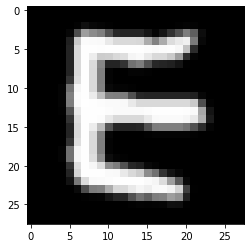

In [ ]:
#first example
image_index = 444
single_image = train_images[image_index].reshape(28,28) 
plt.imshow(single_image,cmap='gist_gray') 

In [ ]:
char_predictor(train_images[image_index])

INFO:tensorflow:Restoring parameters from my_models/model_char_recog.ckpt
The predicted character is :- E


In [ ]:
# predicting on images given by user

In [ ]:
#function to convert user image into image suitable for the dataset

In [ ]:
from PIL import Image, ImageFilter


def imageprepare(argv):
    """
    This function returns the pixel values.
    The imput is a image file location.
    """
    try:
      my_image = Image.open(argv).convert('L')    #.convert() Returns a converted copy of this image. Mode L means 8-bit pixels, black and white
    except:
      print("Sorry! No such file found. Please enter full path of file along with extension")
      return  
        
    width, height = my_image.size
    new_image = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels . 
    

    if width > height:  
        #occupy all the width and change the height according to height-width ratio
        new_height = int(round(((28.0 / width )* height),0)) 
        if (new_height == 0):  # keeping minimum  1 pixel
            new_height = 1

        # resize and sharpen
        #Image sharpening refers to any enhancement technique that highlights edges and fine details in an image.
        image = my_image.resize((28, new_height), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        #anti-aliasing. : a procedure used in digital graphics processing for smoothing lines and removing visual distortions.
        #The class ImageFilter.SHARPEN implements a spatial filter using convolution to sharpen a given image.
        #To get a filter applied onto an image the filter() method is called on the Image object. Name of filter class passed to it is ImageFilter.SHARPEN
        #The convolution matrix used is, ((-2, -2, -2),(-2, 32, -2),(-2, -2, -2)) ;a 3x3 matrix.The filter() method applies the convolution matrix to the 
        # image pixels and returns the sharpened image.

        #trying to keep the image in centre of canvas
        position = int(round(((28 - new_height) / 2), 0))  
        new_image.paste(image, (0, position))  # paste resized image on top of white canvas
    else:
        #occupy all the height and change the width according to height-width ratio
        new_width = int(round((28.0 / height * width), 0)) 
        if (new_width == 0):  
            new_width = 1
            
        # resize and sharpen
        image = my_image.resize((new_width, 28), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        position = int(round(((28 - new_width) / 2), 0))  
        new_image.paste(image, (position, 0))  # paste resized image on top of white canvas


    lis = list(new_image.getdata())   #getdata() returns a sequence of data. The sequence object is flattened,i.e, one dimensional
    # normalizing pixels to 0 and 1. 
    final_img = [(255 - x) * 1.0 / 255.0 for x in lis]
    #print(tva)
    for i in range(len(final_img)):
        if final_img[i]<=0.45:
            final_img[i]=0.0
    return final_img

Inputs from outside of dataset

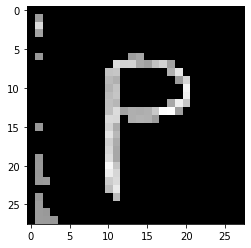

In [ ]:
#first example
my_img=imageprepare('./P.jpg')#file path here
my_img=np.array(my_img)
plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 

In [ ]:
char_predictor(my_img)

INFO:tensorflow:Restoring parameters from my_models/model_char_recog.ckpt
The predicted character is :- P


In [ ]:
# example 2

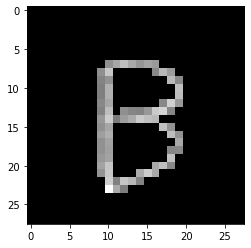

In [ ]:
my_img=imageprepare('./B.jpg')#file path here
my_img=np.array(my_img)
plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 

In [ ]:
char_predictor(my_img)

INFO:tensorflow:Restoring parameters from my_models/model_char_recog.ckpt
The predicted character is :- B


In [ ]:
#example 3

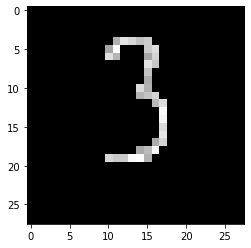

In [ ]:
my_img=imageprepare('./3.jpg')#file path here
my_img=np.array(my_img)
plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 

In [ ]:
char_predictor(my_img)

INFO:tensorflow:Restoring parameters from my_models/model_char_recog.ckpt
The predicted character is :- 2


In [ ]:
#example 4

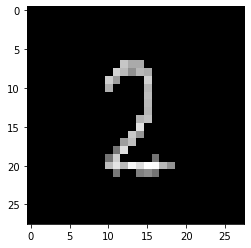

In [ ]:
my_img=imageprepare('./2.jpg')#file path here
my_img=np.array(my_img)
plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 

In [ ]:
char_predictor(my_img)

INFO:tensorflow:Restoring parameters from my_models/model_char_recog.ckpt
The predicted character is :- 2


In [ ]:
def predict_my_image():
  img=input("Please enter path of image file:- \n")
  my_img=imageprepare(img)#file path here
  my_img=np.array(my_img)
  if my_img.size==1:
    return
  plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 
  char_predictor(my_img)

**Please Run this last cell and give in the image file to predict the character inside it**

Please enter path of image file:- 
./character_images/D1.png
INFO:tensorflow:Restoring parameters from my_models/model_char_recog.ckpt
The predicted character is :- D


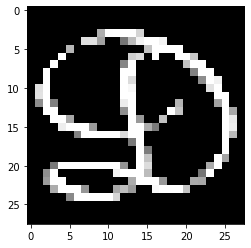

In [ ]:
predict_my_image()